## Adapted from 

* https://gist.github.com/GeorgeVJose (https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

* https://machinelearningmastery.com/

# More resources

* https://github.com/DarkKnight1991/Stock-Price-Prediction/blob/master/stock_pred_main.py

* https://github.com/FelixMohr/eth-price-prediction/blob/master/lstm.ipynb

* lstm from scratch
https://www.kaggle.com/navjindervirdee/lstm-neural-network-from-scratch

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import sys

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


There are missing values indicated with a ‘?‘ in this data. These values can be converted into NaN value, which is a float.



In [0]:
data_dir = '../gdrive/My Drive/colab/lstm'
sys.path.append(data_dir)

The dataset contains missing values (NaNs now) that we need to fill. 

In [4]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '../gdrive/My Drive/colab/lstm']

In [6]:
filename = "../gdrive/My Drive/colab/lstm/goog.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 8 columns):
Sym          1258 non-null object
Date         1258 non-null object
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Volume       1258 non-null int64
Adj Close    1258 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 78.7+ KB
None
    Sym       Date    Open    High     Low   Close   Volume  Adj Close
0  GOOG   4/7/2010  567.30  568.75  561.86  563.54  2581000     563.54
1  GOOG   4/6/2010  569.46  570.89  565.40  568.22  2060100     568.22
2  GOOG   4/5/2010  570.90  574.88  569.00  571.01  1901500     571.01
3  GOOG   4/1/2010  571.35  573.45  565.55  568.80  2102700     568.80
4  GOOG  3/31/2010  565.05  569.74  562.81  567.12  3030800     567.12


!!


In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

In [8]:
print(df.head())
df.tail()

             Sym       Date   Close  Adj Close
Date                                          
2010-04-07  GOOG 2010-04-07  563.54     563.54
2010-04-06  GOOG 2010-04-06  568.22     568.22
2010-04-05  GOOG 2010-04-05  571.01     571.01
2010-04-01  GOOG 2010-04-01  568.80     568.80
2010-03-31  GOOG 2010-03-31  567.12     567.12


,Sym,Date,Close,Adj Close
Date,,,,
2005-04-14,GOOG,2005-04-14,191.45,191.45
2005-04-13,GOOG,2005-04-13,192.93,192.93
2005-04-12,GOOG,2005-04-12,193.96,193.96
2005-04-11,GOOG,2005-04-11,193.23,193.23
2005-04-08,GOOG,2005-04-08,192.05,192.05


In [9]:
df = df.reindex(df.index[::-1])
print(df.head())
print(df.tail())

             Sym       Date   Close  Adj Close
Date                                          
2005-04-08  GOOG 2005-04-08  192.05     192.05
2005-04-11  GOOG 2005-04-11  193.23     193.23
2005-04-12  GOOG 2005-04-12  193.96     193.96
2005-04-13  GOOG 2005-04-13  192.93     192.93
2005-04-14  GOOG 2005-04-14  191.45     191.45
             Sym       Date   Close  Adj Close
Date                                          
2010-03-31  GOOG 2010-03-31  567.12     567.12
2010-04-01  GOOG 2010-04-01  568.80     568.80
2010-04-05  GOOG 2010-04-05  571.01     571.01
2010-04-06  GOOG 2010-04-06  568.22     568.22
2010-04-07  GOOG 2010-04-07  563.54     563.54


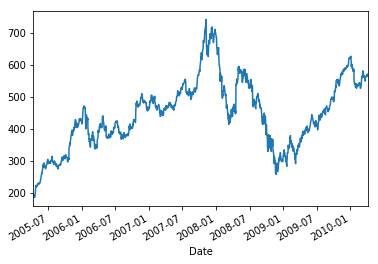

In [10]:
from matplotlib import pyplot
df.Close.plot()
pyplot.show()
#https://machinelearningmastery.com/time-series-data-visualization-with-python/

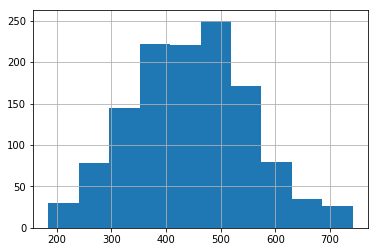

In [11]:
df.Close.hist()
pyplot.show()

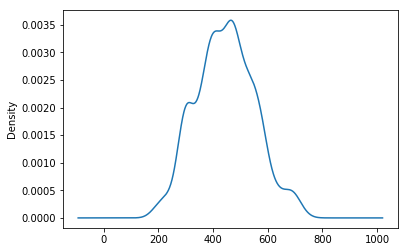

In [12]:
df.Close.plot(kind='kde')
pyplot.show()

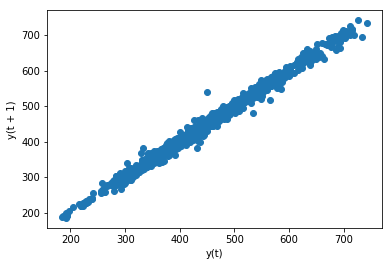

In [13]:
from pandas.plotting import lag_plot
lag_plot(df.Close)
pyplot.show()

In [14]:
close_data = df['Close'].values
print(len(close_data))
print(close_data)
close_data = close_data.reshape((-1,1))
print(len(close_data))
print(close_data)

split_percent = 0.80
split = int(split_percent*len(close_data))


close_train = close_data[:split]

close_test = close_data[split:]


date_train = df['Date'][:split]
print("Date - Train start +++++++++++++++++++")
print(date_train.head())
print("+++++++++++++++++++")
date_test = df['Date'][split:]
print("Date - Test start +++++++++++++++++++")
print(date_test.head())
print("+++++++++++++++++++")

print(len(close_train))
print(len(close_test))

1258
[192.05 193.23 193.96 ... 571.01 568.22 563.54]
1258
[[192.05]
 [193.23]
 [193.96]
 ...
 [571.01]
 [568.22]
 [563.54]]
Date - Train start +++++++++++++++++++
Date
2005-04-08   2005-04-08
2005-04-11   2005-04-11
2005-04-12   2005-04-12
2005-04-13   2005-04-13
2005-04-14   2005-04-14
Name: Date, dtype: datetime64[ns]
+++++++++++++++++++
Date - Test start +++++++++++++++++++
Date
2009-04-07   2009-04-07
2009-04-08   2009-04-08
2009-04-09   2009-04-09
2009-04-13   2009-04-13
2009-04-14   2009-04-14
Name: Date, dtype: datetime64[ns]
+++++++++++++++++++
1006
252


## Experiment 1
Simple LSTM with a small hidden state
1. Hidden state = 10
2. Activation = "relu"
3. look_back = 15 
4. batch_size_train = 20
5. batch_size_test = 1
6. num_epochs = 25

In [0]:
hidden_size = 50
look_back = 15
batch_size_traingen = 20
batch_size_testgen = 1
num_epochs = 5
optimizer = 'adam'


In [0]:
# https://keras.io/preprocessing/sequence/
#train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=batch_size_traingen)     
#test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=batch_size_testgen)
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=batch_size_traingen)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [19]:
# Here 2 points are input and every two points are output
batch_0 = train_generator[0]
x, y = batch_0
print("++++++++++++++")
print(np.array(x[0]))
print("++++++++++++++")
print(np.array(y[0]))
print("++++++++++++++")
print(close_train[0:10])

++++++++++++++
[[192.05]
 [193.23]
 [193.96]
 [192.93]
 [191.45]
 [185.  ]
 [186.97]
 [191.4 ]
 [198.1 ]
 [204.22]
 [215.81]
 [223.53]
 [218.75]
 [219.78]
 [219.45]]
++++++++++++++
[220.]
++++++++++++++
[[192.05]
 [193.23]
 [193.96]
 [192.93]
 [191.45]
 [185.  ]
 [186.97]
 [191.4 ]
 [198.1 ]
 [204.22]]


In [20]:
print(test_generator[1])

(array([[[362.  ],
        [372.5 ],
        [378.11],
        [368.91],
        [379.5 ],
        [388.74],
        [392.24],
        [379.3 ],
        [381.47],
        [383.86],
        [384.69],
        [389.49],
        [385.95],
        [383.71],
        [391.47]]]), array([[395.97]]))


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(hidden_size,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 3s 53ms/step - loss: 15879.3612
Epoch 2/5
50/50 [==============================] - 1s 15ms/step - loss: 432.3700
Epoch 3/5
50/50 [==============================] - 1s 16ms/step - loss: 414.9725
Epoch 4/5
50/50 [==============================] - 1s 17ms/step - loss: 912.5701
Epoch 5/5
50/

In [22]:
import plotly.graph_objects as go
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()